**İçindekiler**
```
1. Tanıtım
2. Önemli İçe Aktarımlar ve Yardımcı İşlev Fonksiyonları
3. Tensorflow Veri Kümesi
4. Tensorflow Veri Kümesinden Food101 Verilerinin Keşfi
5. Verileri Ön İşleme Ve Bir Fonksiyon
6. Model Kontrol Noktası
7. Mixed Precision
8. Özellik Çıkarımı - Modelin Yazılması
9. Kontrol Noktası Ağırlıklarının Yüklenmesi Ve Yeni Model Yazma Fonksiyonu
10. Modelin Kaydedilmesi Ve Değerlendirilmesi
11. Modelin Katmanlarına İnce Ayar Uygulama
12. Önceden Hazırlanmış İnce Ayarlı Bir Modelin İndirilmesi ve Sonuçlarının İncelenmesi ve Tensorboard
13. Kaynakça
```

# **1. Tanıtım**

Food101 veri kümesindeki tüm verileri kullanarak Food Vision Big™' çalışması konu edilmiştir, 75.750 eğitim görüntüsü ve 25.250 test görüntüsü vardır --> https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

%77.4 doğruluk elde etmek için 2-3 gün boyunca eğitilmiş bir Evrişimli Sinir Ağı kullanan 2016 tarihli bir makale olan DeepFood'u yenme hedefimiz var. https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment

🔑 Not: En iyi-1 doğruluğu, "model tarafından en yüksek softmax aktivasyon değeri çıktısı için doğruluk" anlamına gelir (çünkü softmax her sınıf için bir değer üretir, ancak ilk 1 yalnızca en yüksek olanın değerlendirildiği anlamına gelir). En iyi 5 doğruluğu, "model tarafından üretilen en iyi 5 softmax aktivasyon değeri için doğruluk" anlamına gelir, başka bir deyişle, gerçek etiket ilk 5 aktivasyon değerinde göründü mü? İlk 5 doğruluk puanları genellikle ilk 1'den belirgin şekilde daha yüksektir.

**Food Vision Big / Food Vision Mini**

Daha önce bu veri setinin %10luk miktarı ile çalışılmıştı (Food Vision Mini de denilebilir), ikisi arasındaki farklar;

* Veri Kaynağı: Tensorflow Dataseti / Kaggle'ın ön işlenmiş dataseti
* Eğitim Data: 75750 fotoğraf / 7575 fotoğraf
* Test Data: 25250 fotoğraf ikisi de
* Karışık Değerlendirme: Evet / Hayır
* Veri Yükleme: Performanant tf.data API / TensorFlow pre-built function
* Hedef Sonuç: %77.4 https://arxiv.org/abs/1606.05675/ %50.76 https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Bu not defterinde karışık hassasiyet eğitimi kullanıldı --> https://www.tensorflow.org/guide/mixed_precision?hl=tr

Karışık hassasiyet eğitimi, model eğitimini hızlandırmak için tek hassasiyet (float32) ve half-preicison (float16) veri türlerinin bir kombinasyonunu kullanır (modern GPU'larda 3 kat daha hızlı).

# **2. Önemli İçe Aktarımlar ve Yardımcı İşlev Fonksiyonları**

Karışık hassasiyet eğitiminin çalışması için, 7.0+ bilgi işlem uyumluluğu puanına sahip bir GPU'ya erişmeniz gerekir.

Google Colab birkaç çeşit GPU sunar. Bununla birlikte, bazıları karışık hassasiyet eğitimi ile uyumlu değildir.

Bu nedenle, Google Colab'da karışık hassasiyet eğitimine erişebildiğinizden emin olmak için Nvidia'nın geliştirici web sitesinde GPU hesaplama yetenek puanınızı kontrol edebilirsiniz. https://developer.nvidia.com/cuda-gpus#compute

Mayıs 2023 itibariyle, Google Colab'da bulunan ve karışık hassasiyet eğitiminde kullanabileceğimiz GPU'lar şunlardır:

* NVIDIA A100 (Google Colab Pro ile kullanılabilir)

* NVIDIA Tesla T4

In [ ]:
# GPU kullanılıyor mu?
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a63b4ea1-cde9-1cc4-4d8c-f8ec861bbddc)


In [ ]:
# Not: Mayıs 2023 itibarıyla TensorFlow 2.9-2.12 sürümlerinde bazı sorunlar yaşanmıştır.
# aşağıdaki kodla.
# Ancak bunlar 2.13+ sürümünde düzeltilmiş görünüyordu.
# TensorFlow sürüm 2.13, Mayıs 2023 itibarıyla tf-nightly olarak kullanıma sunuldu (yakında Google Colab'da varsayılan olacak).
# Bu nedenle hataları önlemek için öncelikle tf-nightly kurulumunu yapacağız.
# Daha fazlasını burada görün: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/550

# tf-nightly'yi yükleyin (Google Colab'da 2.13.0+ sürümüne kadar gereklidir
!pip install -U -q tf-nightly

# TensorFlow sürümünü kontrol edin (minimum 2.4.0+ olmalıdır ancak 2.13.0+ daha iyidir)
import tensorflow as tf
print(f"TensorFlow versiyonunuz: {tf.__version__}")

# Zaman damgası ekle
import datetime
print(f"Bu çalışma kitabının son çalışma tarihi: {datetime.datetime.now()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.2 MB/s eta 0:00:00
TensorFlow versiyonunuz: 2.19.0-dev20241210
Bu çalışma kitabının son çalışma tarihi: 2024-12-11 09:27:35.590008


In [ ]:
# Yardımcı fonksiyonlar dosyası
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

# Dizüstü bilgisayar için bir dizi yardımcı işlevi içe aktarın
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-12-11 09:27:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-11 09:27:51 (80.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
### Bazı yardımcı fonksiyonlar

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

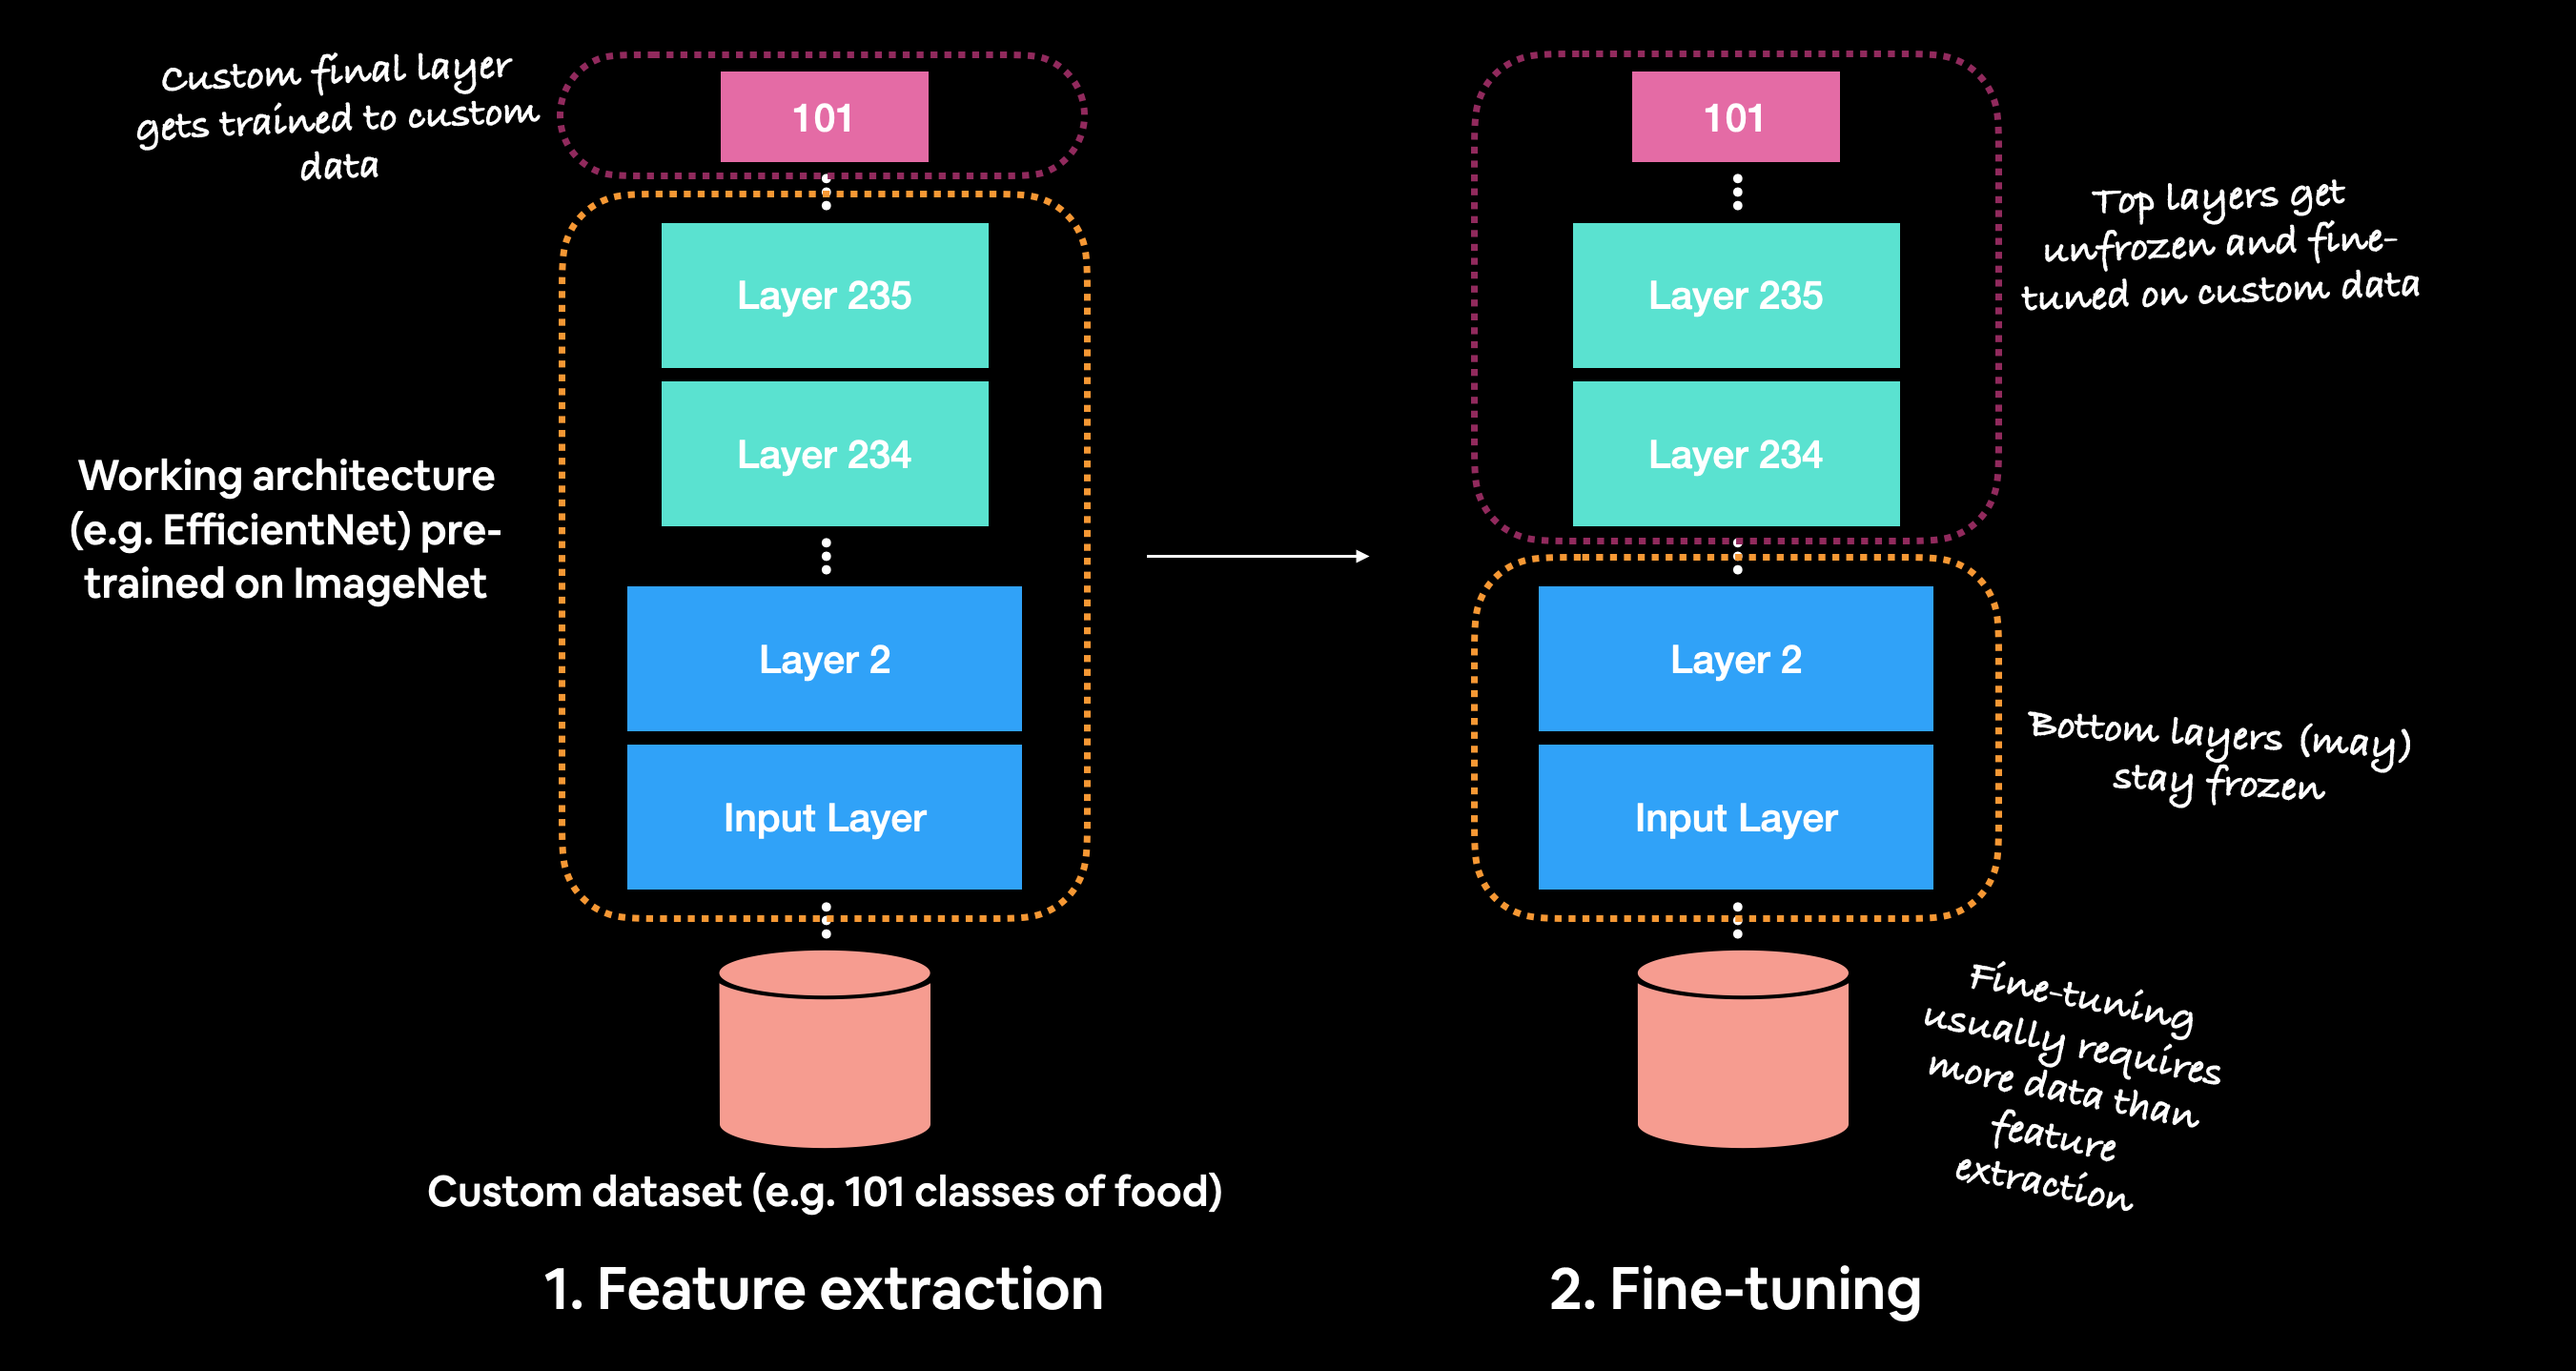

In [ ]:
from IPython.display import display, Image

# Resmin URL'si
image_url = "https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/07-feature-extraction-then-fine-tune.png"

# Resmi göster
display(Image(image_url))

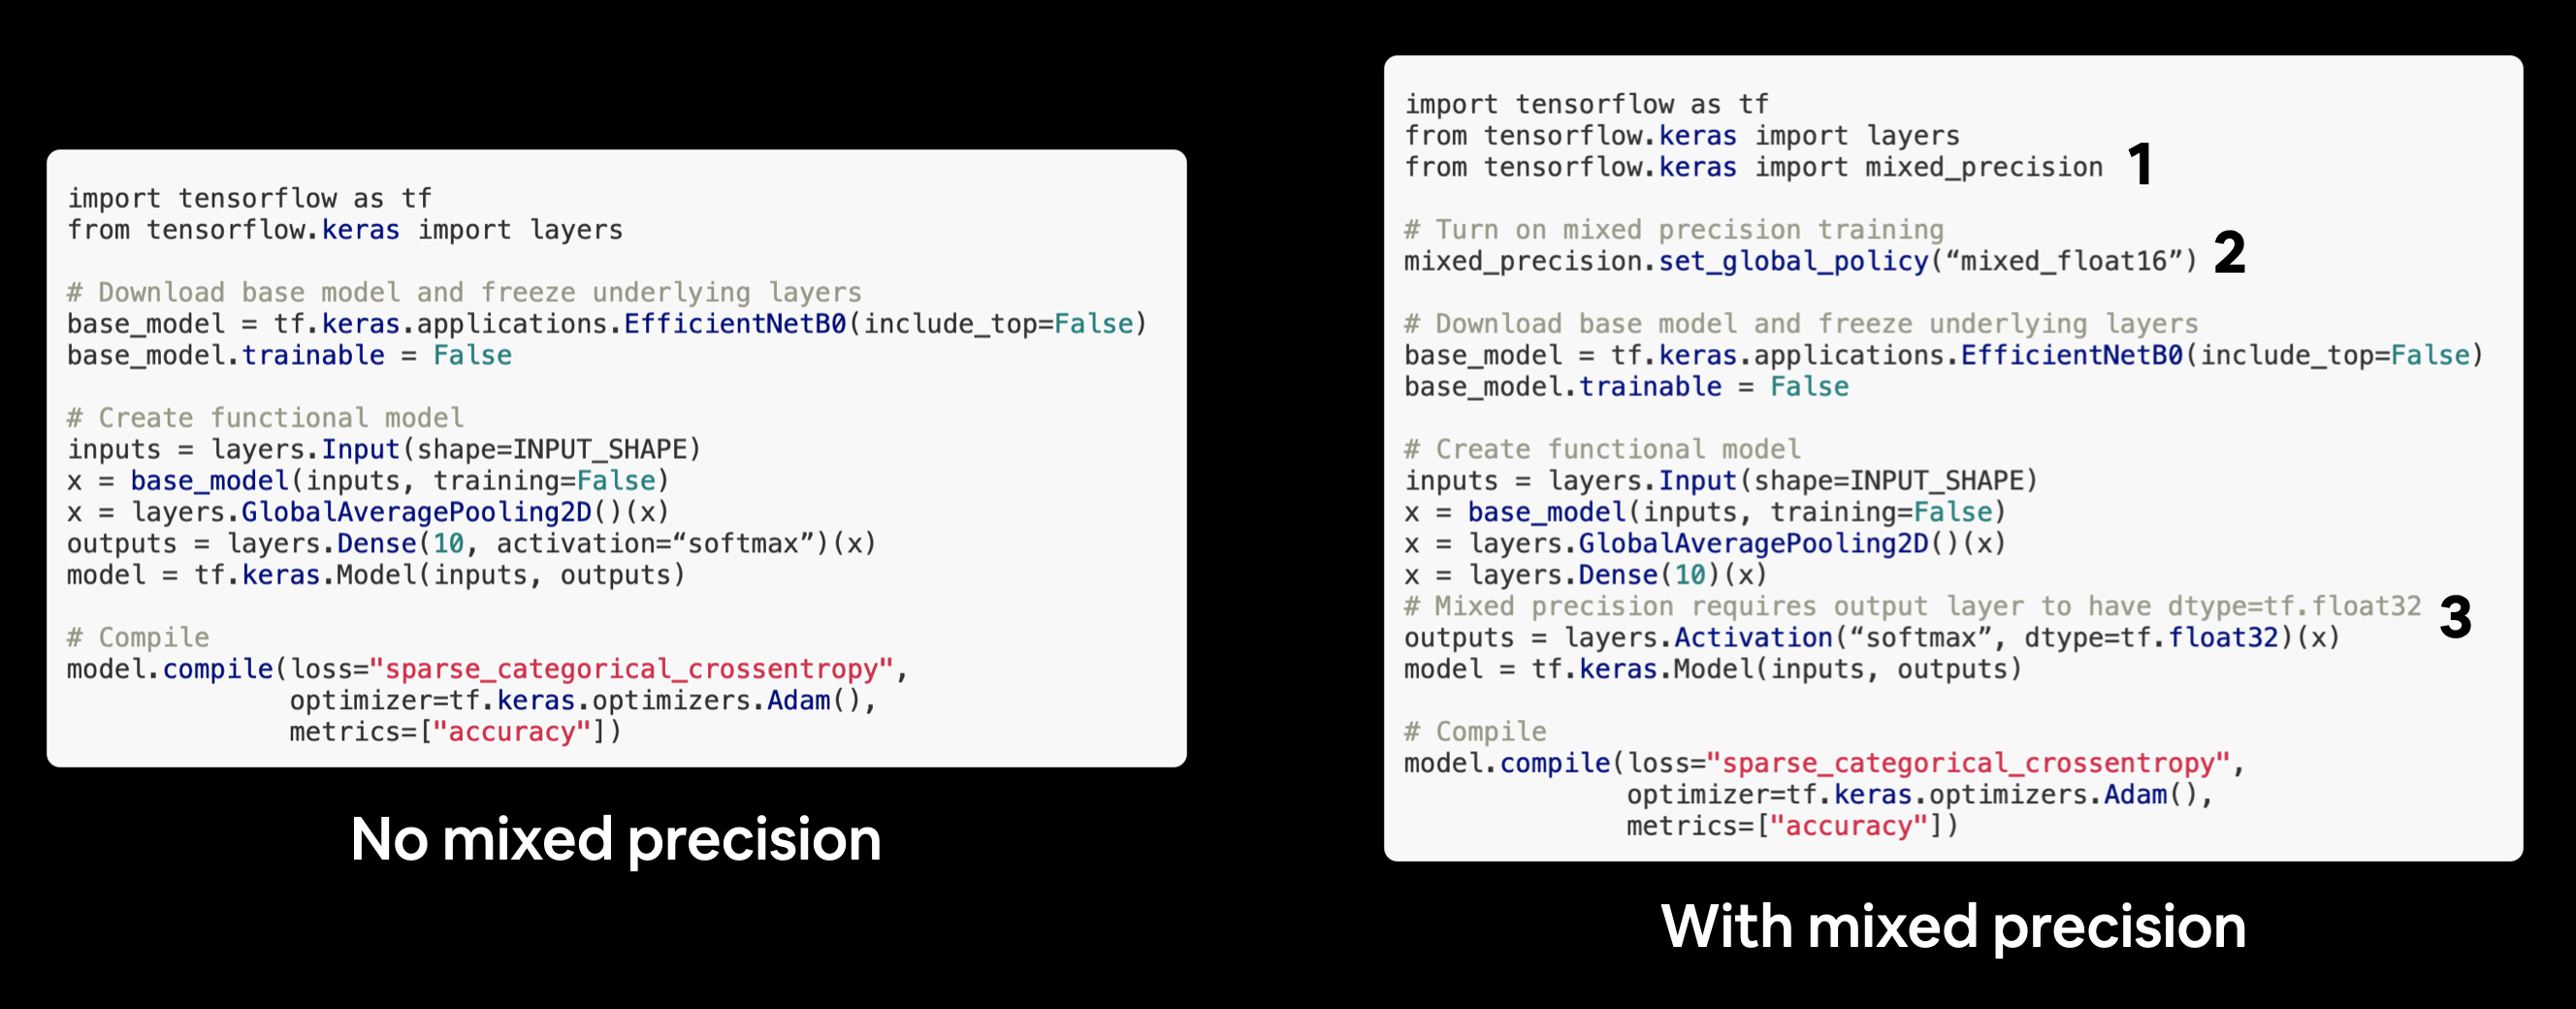

In [ ]:
from IPython.display import display, Image

# Resmin URL'si
image_url = "https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/07-mixed-precision-code-before-and-after.png"

# Resmi göster
display(Image(image_url))

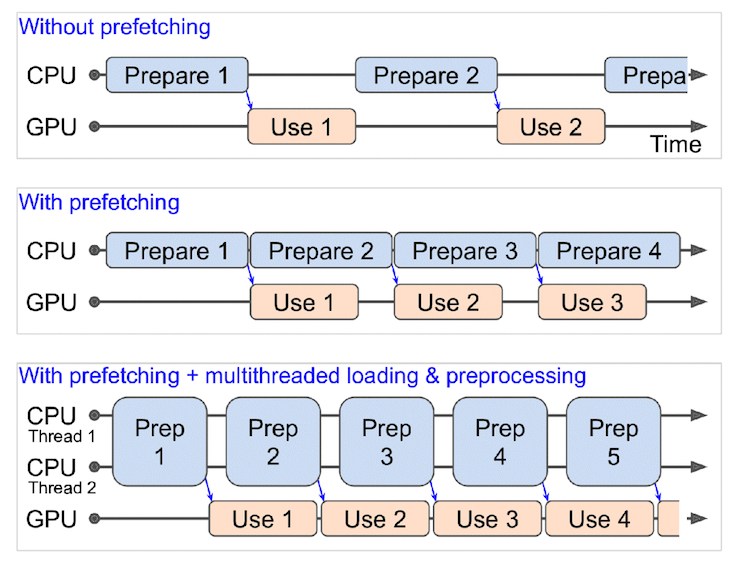

In [ ]:
from IPython.display import display, Image

# Resmin URL'si
image_url = "https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/07-prefetching-from-hands-on-ml.png"

# Resmi göster
display(Image(image_url))

# **3. Tensorflow Veri Kümesi**

Gıda resimlerimizi (Food101 veri kümesinden) Google Storage'dan indirilebilir --> https://www.kaggle.com/datasets/dansbecker/food-101

Ve bu, kendi veri kümeleriniz üzerinde çalışıyorsanız kullanabileceğiniz tipik bir iş akışıdır.

Ancak, veri kümelerini TensorFlow ile kullanıma hazır hale getirmenin başka bir yolu var.

Makine öğrenimi dünyasındaki en popüler veri kümelerinin çoğu için (genellikle kıyaslama olarak adlandırılır ve kullanılır), bunlara TensorFlow Veri Kümeleri (TFDS) aracılığıyla erişebilirsiniz. https://www.tensorflow.org/datasets/overview?hl=tr

**TensorFlow Veri Kümeleri nedir?**

Hazırlanmış ve kullanıma hazır makine öğrenimi veri kümeleri için bir yer.

**Neden TensorFlow Veri Kümelerini kullanmalı?**

* Verileri zaten Tensors'a yüklenmiştir
* İyi kurulmuş veri kümeleri üzerinde uygulama
* Farklı veri yükleme teknikleriyle denemeler yapabilirsiniz
* Yeni TensorFlow özelliklerini hızlı bir şekilde deneyebilirsiniz (karışık hassasiyet eğitimi gibi)

**Neden TensorFlow Veri Kümelerini kullanmamalı?**

* Veri kümeleri statiktir (real-world veri kümelerinizin yapacağı gibi değişmezler)
* Özel sorununuz için uygun olmayabilir

In [ ]:
# TensorFlow Veri Kümelerini Alın
import tensorflow_datasets as tfds

In [ ]:
# TFDS'deki kullanılabilir tüm veri kümelerini bulmak için
datasets_list = tfds.list_builders()

# Hedef veri kümemizi belirleyin ve var olup olmadığına bakın
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


Çok fazla veri kümesi olmakla birlikte food101 veri kümesi içeride kayıtlıymış.

TFDS'den Food101 veri kümesine erişmek için tfds.load() yöntemini kullanabiliriz --> https://www.tensorflow.org/datasets/api_docs/python/tfds/load

Özellikle, ne peşinde olduğumuzu bildirmek için birkaç parametre geçmemiz gerekecek:

**Split (liste, isteğe bağlı) :** --> https://github.com/tensorflow/datasets/blob/master/docs/splits.md

🔑 Not: tfds.load() yönteminin çağrılması, download=True parametresi ayarlanmışsa (varsayılan) diske bir hedef veri kümesi indirmeye başlar. Bu veri kümesi 100GB+ olabilir, bu yüzden alanınız olduğundan emin olun.

In [ ]:
# Verileri yükleyin (Google Colab'da yaklaşık 5-6 dakika sürer)

(train_data, test_data), ds_info = tfds.load(
    name="food101", # TFDS'den alınacak hedef veri kümesi
    split=["train", "validation"], # hangi veri bölümlerini almalıyız? not: tüm veri kümelerinde eğitim, geçerlilik, test yoktur
    shuffle_files=True, # İndirirken dosyalar karıştırılsın mı? Varsayılan False
    as_supervised=True, # verileri tuple formatında indirin (örnek, etiket), ör. (resim, etiket) sözlük formatı için False
    with_info=True # veri kümesi meta verileri dahil edilsin mi? eğer öyleyse, tfds.load() işlevi tuple'ı (data, ds_info) döndürür
    )

**with_info=True**

   `with_info=True` parametresi, TensorFlow Datasets (TFDS) veri kümesini yüklerken meta verilerinin de dahil edilmesini sağlar. Bu meta veriler, veri kümesinin özellikleri, etiketlerin açıklamaları, veri kümesinin toplam boyutu, örnek sayısı gibi bilgileri içerir.

   Örneğin, veri kümesinin kaç sınıf içerdiği, her sınıfın kaç örneğe sahip olduğu, hangi görsel formatında verilerin bulunduğu gibi bilgiler, veri kümesinin özelliklerini tanımlayan meta verilerde bulunur.

   Eğer `with_info=False` olarak ayarlanırsa, yalnızca veriler (örneğin, resimler ve etiketler) döndürülür ve meta bilgiler atlanır.

---

**as_supervised=True**

   `as_supervised=True` parametresi, veri kümesini **denetimli öğrenme** formatında döndürür. Bu durumda, veri kümesindeki her örnek bir **(input, label)** çiftine dönüştürülür. Bu, genellikle resimler için bir veri kümesi kullanırken etiketlerin (sınıfların) veya hedeflerin belirtilmesi gereken durumlarda kullanılır.

   **Çıktı formatı:**
   - **input**: Giriş verisi, genellikle bir görüntü olur (örneğin, bir NumPy dizisi veya TensorFlow tensörü).
   - **label**: Etiket verisi, genellikle bu örneğin ait olduğu sınıfı belirten bir sayıdır (örneğin, resim bir yemek türünü sınıflandırıyorsa, etiket o yemeğin sınıf numarasını içerir).

---

**(train_data, test_data), ds_info = tfds.load()**

   `tfds.load()` fonksiyonu, TensorFlow Datasets (TFDS) kütüphanesinin veri kümesi yükleme fonksiyonudur. Bu fonksiyon, veri kümesinin eğitim, test, doğrulama gibi farklı bölümlerini indirmenizi sağlar. İlgili veri kümesinin her bölümü (örneğin, `train`, `test`, `validation` gibi) ayrı ayrı indirilebilir.

   `split=["train", "validation"]` parametresi ile belirtilen veri kümeleri **eğitim** ve **doğrulama** (validation) verilerini indirir. Ancak `food101` veri kümesinde **test** verisi, doğrulama verisi olarak kullanılabilir ve test verisi çoğu zaman tek bir genel veri kümesi olarak sunulmaz. Bu durum veri kümesinin yapısına bağlıdır.

   **Validation verisi**: Genellikle doğrulama verisi (`validation`) modelin eğitim sırasında modelin genel performansını değerlendirmek için kullanılır. Bazı veri kümelerinde test seti, doğrulama verisi olarak kullanılabilir. Ancak, orijinal veri kümesinde **test seti** bazen `split` parametresi ile belirtilmez, çünkü doğrulama (validation) ve eğitim (train) seti üzerine yoğunlaşılır. Bu durumda, test verisini farklı şekilde temin edebilirsiniz.

Birkaç dakika indirdikten sonra, artık modelleme için hazır olan tüm Food101 veri kümesine (tensör formatında) erişebiliyoruz.

Şimdi sınıf adlarından başlayarak veri kümemizden biraz bilgi alalım.

Bir TensorFlow Datasets veri kümesinden sınıf adlarını almak, "dataset_info" değişkenini indirmeyi gerektirir (tfds.load() yönteminde as_supervised=True parametresini kullanarak, not: bu yalnızca TFDS'deki denetimli veri kümeleri için çalışacaktır).

Dataset_info.features özniteliğini kullanarak ve "label" anahtarının names özniteliğine erişerek belirli bir veri kümesinin sınıf adlarına erişebiliriz.

In [ ]:
# Food101 TFDS'nin Özellikleri
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Sınıf adlarını alın
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# **4. Tensorflow Veri Kümesinden Food101 Verilerinin Keşfi**

Veri kümemiz hakkında birkaç ayrıntı öğrenelim:

* Giriş verilerimizin şekli (görüntü tensörleri)
* Giriş verilerimizin veri tipi
* Giriş verilerimizin etiketleri nasıl görünüyor (örneğin, tek sıcak kodlu ve etiket kodlu)
* Etiketler sınıf adlarıyla eşleşiyor mu?

Bunu yapmak için, eğitim verilerinden bir örnek alalım (.take() yöntemini kullanarak) ve onu keşfedelim. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take

In [ ]:
# Eğitim verilerinden bir örnek alın
train_one_sample = train_data.take(1) # örnekler biçimindedir (image_tensor, label)

# Yukarıdaki tfds.load() yöntemimizde as_supervised=True parametresini kullandığımız için, --
# veri örnekleri demet biçimi yapısında (veri, etiket) veya bizim durumumuzda (image_tensor, etiket) gelir

# Eğitim verilerimizin bir örneği neye benziyor?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Eğitim örneğimiz hakkında çıktı bilgisi
for image, label in train_one_sample:
  print(f"""
  Görüntü şekli: {image.shape}
  Görüntü tipi: {image.dtype}
  Food101'den hedef sınıf (tensör formu): {label}
  Sınıf adı (str formu): {class_names[label.numpy()]}
        """)  # One hot encoding formatında olsaydı şekiller [0,0, 1, 0 .. 0] gibi görünürdü


  Görüntü şekli: (489, 512, 3)
  Görüntü tipi: <dtype: 'uint8'>
  Food101'den hedef sınıf (tensör formu): 90
  Sınıf adı (str formu): spaghetti_bolognese
        


Yukarıdaki tfds.load() yöntemimizde shuffle_files=True parametresini ayarladığımız için, hücreyi birkaç kez çalıştırmak her seferinde farklı bir sonuç verecektir.

Bunları kontrol ederek, bazı görüntülerin farklı şekillere sahip olduğunu fark edebilirsiniz, örneğin (512, 342, 3) ve (512, 512, 3) (yükseklik, genişlik, renk_kanalları).

In [ ]:
# TFDS'nin Food101'indeki görüntü tensörü neye benziyor?
image

<tf.Tensor: shape=(489, 512, 3), dtype=uint8, numpy=
array([[[ 83,  71,  45],
        [ 81,  69,  43],
        [ 80,  68,  44],
        ...,
        [186, 183, 142],
        [188, 185, 144],
        [185, 182, 141]],

       [[ 86,  74,  48],
        [ 83,  71,  45],
        [ 82,  70,  46],
        ...,
        [180, 177, 136],
        [179, 176, 135],
        [182, 179, 138]],

       [[ 88,  76,  52],
        [ 87,  75,  51],
        [ 85,  73,  49],
        ...,
        [188, 185, 144],
        [186, 183, 142],
        [187, 184, 143]],

       ...,

       [[162, 163, 168],
        [164, 165, 170],
        [171, 170, 176],
        ...,
        [ 75,  74,  56],
        [ 67,  66,  48],
        [ 64,  63,  45]],

       [[168, 169, 174],
        [175, 176, 181],
        [167, 166, 172],
        ...,
        [ 79,  78,  60],
        [ 74,  73,  55],
        [ 79,  78,  60]],

       [[182, 183, 188],
        [178, 179, 184],
        [163, 164, 169],
        ...,
        [ 75,  74,  5

In [ ]:
# Minimum ve maksimum değerler nelerdir?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Görüntü tensörlerimizin değerleri 0 ile 255 arasında (standart kırmızı, yeşil, mavi renk değerleri) ve değerler veri tipi birim8 gibi görünüyor.

**Bir görüntü çizelim:**

Matplotlib.pyplot.imshow() kullanarak görüntü örneklerinden birini çizelim ve başlığı hedef sınıf adına ayarlayalım. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

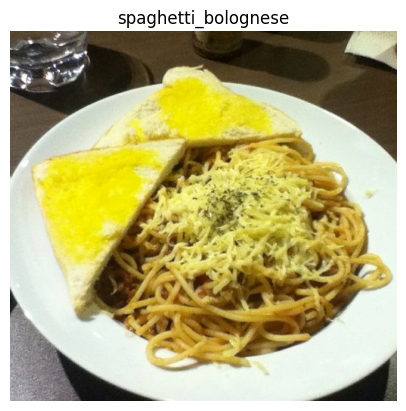

In [ ]:
# Bir görüntü tensörünün grafiğini çizin
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # class_names listesinde indeksleyerek resme başlık ekleyin
plt.axis(False);

Nöral ağlar batch, normalleştirilmiş vb formlarda iyi performans gösterir. Tensörflow dataseti böyle değildir. Bunu sağlamak için preprocessing fonks. yazmalısınız ve veriler ile eşlemelisin.

# **5. Verileri Ön İşleme Ve Bir Fonksiyon**

Önceki not defterlerinde, görüntülerimiz klasör biçimindeyken, bunları yüklemek için tf.keras.utils.image_dataset_from_directory() yöntemini kullandık --> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Bunu yapmak, verilerimizin modellerimizle kullanılmaya hazır bir formata yüklendiği anlamına geliyordu.

Ancak, TensorFlow Datasets'ten verileri indirdiğimiz için, modellemeye hazır olmadan önce atmamız gereken birkaç ön işleme adımı var. **Verilerimiz şu anda:**

* Uint8 veri türünde
* Tüm farklı boyutlu tensörlerden (farklı boyutlu görüntüler) içerir
* Ölçeklendirilmemiş (piksel değerleri 0 ve 255 arasındadır)

**Oysa veriler gibi modeller:**

* Float32 veri türünde
* Aynı boyuttaki tüm tensörlere sahip olun (toplu tensörler tüm tensörlerin aynı şekle sahip olmasını gerektirir, örn. (224, 224, 3))
* Ölçekli (0 ve 1 arasındaki değerler), normalize olarak da adlandırılır

Bunlarla ilgilenmek için bir **preprocess_img()** işlevi oluşturacağız:

* tf.image.resize() kullanarak bir giriş görüntüsü tensörünü belirli bir boyuta yeniden boyutlandırır https://www.tensorflow.org/api_docs/python/tf/image/resize
* tf.cast() kullanarak bir giriş görüntüsü tensörünün mevcut veri türünü tf.float32'ye dönüştürür https://www.tensorflow.org/api_docs/python/tf/cast

🔑 Not: tf.keras.applications.efficientnet'teki (kullanacağımız şey) önceden eğitilmiş EfficientNetBX modelleri yerleşik olarak yeniden ölçeklendirmeye sahiptir. Ancak diğer birçok model mimarisi için verilerinizi yeniden ölçeklendirmek isteyeceksiniz (örneğin, değerlerini 0 ve 1 arasında alın). Bu, "preprocess_img()" işlevinizin içine (aşağıdaki gibi) veya modelinizin içine bir tf.keras.layers.Rescaling katmanı olarak dahil edilebilir.

* https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling

Yeni fonksiyon ile şunlar yapılabilmeli,
* Görüntülerin hepsini aynı ölçüde yeniden şekillendirmeli.
* Görüntülerin dtype'sını uint8'den float 32'ye dönüştürmeli.

Fonksiyonda bir etiketi almak zorunda olmasının nedeni, şu anda verilerimizin görüntü etiketi biçiminde olmasıdır.

Tüm resimlerin 512 veya 300 olmasını istiyorsan hedef şeklini 224'ten bu rakamlara da çekebilirsin. Genellikle 8'in katlarını gpu iyi hesaplar.

Bu fonksiyonda image = image/255. yapmana gerek yok. EfficientNetBX modelinde buna gerek yok (tf.keras.application). Farklı bir model kullanıyor olsaydık yapardık.

In [ ]:
# Görüntülerin ön işlenmesi için bir işlev oluşturun
# Veri kümemiz şu anda tuple yapısında (görüntü, etiket) olduğu için görüntü ve etiketi --
# girdi olarak alır (etikete hiçbir şey yapmasa da)

def preprocess_img(image, label, img_shape=224):
    """
    Görüntü veri türünü 'uint8' -> 'float32'den dönüştürür ve görüntüyü yeniden şekillendirir
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # img_shape olarak yeniden şekillendir
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple'ı

**Görüntü boyutunu yeniden boyutlandırma:**
   - `tf.image.resize(image, [img_shape, img_shape])`: Bu satır, görüntüyü verilen `img_shape` (varsayılan olarak 224) boyutlarına yeniden boyutlandırır. Bu, modelin belirli bir giriş boyutuna (genellikle `224x224`) uygun hale getirilmesi için yapılır. `image` bu aşamada `uint8` formatında olabilir (0-255 arası tamsayılar). Bu işlem, görüntü boyutunu değiştirir ama veri türünü değiştirmez.

**Görüntü veri türünü dönüştürme:**
   - `tf.cast(image, tf.float32)`: Bu satır, görüntü verisini `uint8` (0-255 arası tam sayılar) türünden `float32` türüne dönüştürür. Görüntü verisi, modelin daha iyi performans göstermesi için genellikle [0, 1] aralığında olacak şekilde normalize edilir. `tf.cast` fonksiyonu, `image`'i `float32` türüne dönüştürür. `uint8`'in 0-255 aralığı, modelin daha iyi çalışabilmesi için 0-1 aralığına dönüştürülmeli, ancak bu işlevde normalizasyon doğrudan yapılmaz. `float32` dönüşümü görüntüyü kayan nokta formatına getirir.

**Etiketin (label) değişmemesi:**
   - `return tf.cast(image, tf.float32), label`: Burada, yalnızca görüntü üzerinde dönüşüm yapılır ve etiket (`label`) olduğu gibi kalır. Etiketin (sınıf etiketleri) değiştirilmesi gerekmez çünkü etiketler zaten doğru biçimdedir. Bu işlev sadece giriş verisi olan `image` üzerinde işlem yapar.

***Tüm TensorFlow Dataset'lerinde Görüntüler Otomatik Olarak Dönüşür Mü?***

Hayır, **tüm TensorFlow Datasets** (TFDS) üzerinde görüntüler otomatik olarak bu şekilde dönüşmez. **Veri ön işleme** işlemi, özellikle modelin ihtiyaçlarına göre belirli bir şekilde yapılmalıdır. Yani, TFDS'den alınan ham veriler genellikle `uint8` formatında gelir ve boyutları da genellikle model için uygun olmayabilir. Bu yüzden, görüntüleri modele beslemeden önce genellikle şu tür ön işleme adımları gerekir:
- **Boyutlandırma**: Görüntüleri modelin beklediği boyutlara (genellikle `224x224` gibi) yeniden boyutlandırma.
- **Veri tipi dönüştürme**: Görüntüyü `float32`'ye dönüştürmek.
- **Normalizasyon**: Görüntü verilerini [0, 1] aralığına getirmek.

TFDS veri kümesindeki her bir veri noktası (görüntü, etiket) aslında bir **tuple** şeklinde gelir. Bu tuple'ı uygun formatta işlemek için kendi **ön işleme işlevinizi** tanımlamanız gerekir.

Örneğin, yukarıda verdiğiniz `preprocess_img` fonksiyonunu, TensorFlow Datasets veri kümesindeki her bir örnek için uygulamak için şu şekilde bir yaklaşım izleyebilirsiniz:

```python
train_data = train_data.map(preprocess_img)
```

Burada, `train_data.map(preprocess_img)` ifadesi, her bir eğitim örneği (görüntü, etiket) üzerinde `preprocess_img` fonksiyonunu uygular ve her bir görüntüyü dönüştürür.

In [ ]:
# Tek bir örnek görüntüyü önceden işleyin ve çıktıları kontrol edin (neye benzediğini görmek için iki örneğe bakıyoruz)
preprocessed_img = preprocess_img(image, label)[0]
print(f"Ön işleme öncesi resim:\n {image[:2]}...,\nŞekil: {image.shape},\nVeri tipi: {image.dtype}\n")
print(f"Ön işleme sonrası resim:\n {preprocessed_img[:2]}...,\nŞekil: {preprocessed_img.shape},\nVeri tipi: {preprocessed_img.dtype}")

Ön işleme öncesi resim:
 [[[ 83  71  45]
  [ 81  69  43]
  [ 80  68  44]
  ...
  [186 183 142]
  [188 185 144]
  [185 182 141]]

 [[ 86  74  48]
  [ 83  71  45]
  [ 82  70  46]
  ...
  [180 177 136]
  [179 176 135]
  [182 179 138]]]...,
Şekil: (489, 512, 3),
Veri tipi: <dtype: 'uint8'>

Ön işleme sonrası resim:
 [[[ 83.108574  71.108574  45.108578]
  [ 82.11161   70.11161   46.11161 ]
  [ 84.873245  72.873245  49.30182 ]
  ...
  [191.5464   188.5464   147.5464  ]
  [184.01991  181.01991  140.01991 ]
  [182.87247  179.87247  138.87247 ]]

 [[ 87.08051   75.08051   51.080517]
  [ 84.33609   72.33609   48.336098]
  [ 83.439735  70.796875  47.439735]
  ...
  [198.13402  195.13402  154.13402 ]
  [194.08138  191.08138  150.08138 ]
  [193.38318  190.38318  149.38318 ]]]...,
Şekil: (224, 224, 3),
Veri tipi: <dtype: 'float32'>


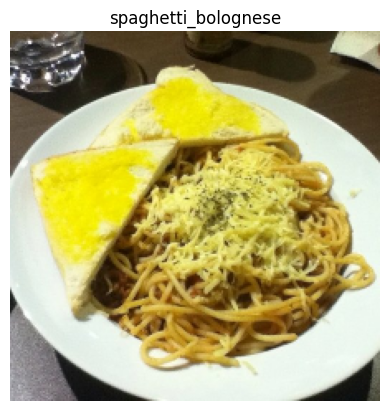

In [ ]:
# Giriş görüntüsü uint8'den float32'ye dönüştürülür ve mevcut şeklinden (224, 224, 3) yeniden şekillenir
# 255'e böldüğümüz sürece önceden işlenmiş görselimizi hala çizebiliriz (matplotlib özelliği için)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

***Verilerimizi modellemeden önce, onu gruplara dönüştürmemiz gerekiyor.*** Çünkü gruplar üzerinde bilgi işlem bellek açısından verimlidir.

Verilerimizi 101.000 görüntü tensörü ve etiketten (eğitme ve test birleştirilmiş) 32 görüntü ve etiket çiftinden oluşan gruplara dönüştürüyoruz, böylece GPU'muzun belleğine sığmasını sağlıyoruz.

Bunu etkili bir şekilde yapmak için tf.data API'sinden bir dizi yöntemden yararlanacağız.

📖 Kaynak: Verileri mümkün olan en performanslı şekilde yüklemek için, tf.data API ile daha iyi performans üzerine TensorFlow docuemntation'a bakın. https://www.tensorflow.org/guide/data_performance?hl=tr

**Özellikle, şunları kullanacağız:**

* **Map()** - önceden tanımlanmış bir işlevi hedef veri kümesine eşler (örn. preprocess_img() görüntü tensörlerimize). Aslında tüm örnekleri alır ve ona verilen bir işlevi uygular (burası için görüntü işleme) https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

* **Shuffle()** - buffer_size'e kadar bir hedef veri kümesinin öğelerini rastgele karıştırır (ideal olarak, buffer_size veri kümesinin boyutuna eşittir, ancak bunun bellek üzerinde etkileri olabilir) https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

* **Batch()** - hedef veri kümesinin öğelerini gruplara dönüştürür (batch_size parametresi ile tanımlanan boyut) https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch

* **Prefetch()** - diğer veri grupları hesaplanırken sonraki veri gruplarını hazırlar (veri yükleme hızını iyileştirir ancak bellek maliyeti). Bir grupta bilgi işlem yaparken veya kalıpları bulurken GPU'daki eğitim verilerinden bu gruptaki başka bir partiyi hazırlar (batch). https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

* **Ekstra: cache()** - önbellekler (daha sonrası için kaydeder) öğeleri bir hedef veri kümesindeki öğeler, yükleme süresinden tasarruf sağlar (yalnızca veri kümeniz belleğe sığacak kadar küçükse çalışır, standart Colab örnekleri yalnızca 12 GB belleğe sahiptir) https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache

**Dikkat edilmesi gerekenler:**

* Farklı şekillerdeki tensörleri toplu olamaz (örneğin, farklı görüntü boyutları, önce görüntüleri yeniden şekillendirmeniz gerekir, dolayısıyla preprocess_img() işlevimiz)

* Shuffle() ilettiğiniz sayının bir tamponunu karıştırılır, ideal olarak bu sayı eğitim setinizdeki tüm örnekler olacaktır, ancak eğitim setiniz büyükse, bu arabellek belleğe sığmayabilir (1000 veya 10000 gibi oldukça büyük bir sayı genellikle karıştırma için yeterlidir)

* Mevcut num_parallel_calls parametresine sahip yöntemler için (map() gibi), bunu ayarlamak tonum_parallel_calls=tf.data.AUTOTUNE ön işlemeyi paralelleştirecek ve hızı önemli ölçüde artıracaktır.

* Veri kümeniz belleğe sığmadığı sürece cache() kullanılamıyor

İşleri şu sırayla gözden geçireceğiz:

Orijinal veri kümesi (örn. train_data) -> map() -> shuffle() -> batch ->() prefetch() -> PrefetchDataset

**Bu fonksiyon için;**

Veri seti tupple formatında image, label. Sadece map_func yazarsak etiket kaçırılır ve eksik olur. Dolayısıyla paralelleştireceğiz Autotune ile. böylece tensör akışı, kullandığı işlev sayısını otomatik olarak ayarlar. Yani varsayılan olarak sadece bu işlem kullanılır. Çok fazla işlem var. Çok fazla örnek olduğu için verileri eşlemekte (map) bunu kullanmak iş kolaylaştırır. Autotune olmadan tek fpu chip kullanır ama onu yazdığında model daha hızlanır.

Yukarıda shuffle kullanmıştık. Aşağıda tekrar kullanmamızın nedeni sadece güvende olmak için, hiçbir ağımızın hiçbir şey öğrenmemesi için tekrar karıştıracağız.

buffer_size --> tek seferde kaç öğenin karıştırılacağıdır. Sahip olduğunuz bellek miktarına bağlı olarak, GPU'nuz veya CPU'nuz veya çalıştırmanız mümkün olmayabilir tüm eğitim veri örneklerini bellekte saklamak için. Yeterli hafızanız varsa, eğitim verilerinin uzunluğuna gönderebilirsiniz.
Ancak, google colab için buna gerek yok.

Normalde test_data kodunun sonuna .cache eklenir. Bu datasette (veri kümelerinde) herhangi bir ön işleme işleviyle karşılaşırsak bunu hafızada saklama işlemi yapar. Veri kümen Ram'ine uyarsa cache çalışır.



In [ ]:
# Ön işleme fonksiyonunu eğitim verileriyle eşleyin (ve paralelleştirin)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# train_data'yı karıştırın ve gruplara dönüştürün ve önceden getirin (daha hızlı yükleyin)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verileri test etmek için ön işleme işlevini eşleyin
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Test verilerini gruplara dönüştürün (karıştırmanıza gerek yok)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Bu veri kümeleri neye benziyor?
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Verilerimiz artık (tf.float32, tf.int64) veri türleriyle (görüntü, etiket) tutples'ta, sadece modelimizin peşinde olduğu gibi görünüyor.

🔑 Not: Veri kümelerinizin sonunda **prefetch()** yöntemini çağırmadan kaçabilirsiniz, ancak bir model oluştururken muhtemelen önemli ölçüde daha düşük veri yükleme hızları görürsünüz. Bu nedenle, veri kümesi giriş boru hatlarınızın çoğu prefecth() çağrısıyla sona ermelidir. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

**Eğitim Verileriyle Ön İşleme Fonksiyonunu Eşleme ve Paralelleştirme**
```python
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
```

- `train_data.map()`: Bu fonksiyon, her bir öğeyi (görüntü, etiket) işlemek için bir ön işleme fonksiyonu uygular. Burada `map_func=preprocess_img` parametresi, her bir veri örneği üzerinde `preprocess_img` fonksiyonunu uygulamayı sağlar.
- **`preprocess_img`** fonksiyonu burada her görüntü üzerinde yeniden boyutlandırma ve tür dönüştürme işlemi gerçekleştirir.
- **`num_parallel_calls=tf.data.AUTOTUNE`**: Bu parametre, TensorFlow'un veri yükleme sürecini paralelleştirmesine olanak tanır. `AUTOTUNE` değeri, TensorFlow'un donanımınızın kapasitesine göre ne kadar paralel işlem yapacağını otomatik olarak ayarlamasını sağlar. Bu, veri işleme hızını artırır ve modelin eğitimi sırasında daha verimli bir veri akışı sağlar.

---

**Eğitim Verilerini Karıştırma, Gruplara Dönüştürme ve Önceden Getirme**
```python
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
```

- **`shuffle(buffer_size=1000)`**: Bu fonksiyon, eğitim verilerini **karıştırma** işlemidir. `buffer_size=1000` parametresi, verilerin 1000 örneği rastgele karıştırılacağı bir **buffer (tampon) alanı** oluşturur. Bu, eğitim sırasında modelin veriye sıralı bir şekilde erişmesini engeller ve modelin daha iyi genelleme yapmasına yardımcı olur. Yüksek buffer boyutları genellikle daha iyi karıştırma sağlar, ancak belleği daha fazla tüketebilir.
  
- **`batch(batch_size=32)`**: Bu adım, verileri **batch'lere (gruplara)** ayırır. Burada her bir batch 32 örnekten oluşur. Bu, modelin eğitiminde her seferinde 32 örnek üzerinde işlem yapılmasını sağlar. **Batch processing**, eğitimde hız sağlar ve aynı zamanda daha verimli bellek kullanımı sağlar.

- **`prefetch(buffer_size=tf.data.AUTOTUNE)`**: `prefetch`, verilerin önceden yüklenmesini sağlar. Yani, model bir batch üzerinde işlem yaparken, bir sonraki batch verisi arka planda yüklenir. Bu işlem, modelin veri bekleme süresini azaltır ve eğitim hızını artırır. `AUTOTUNE` burada, TensorFlow'un hangi verilerin ne zaman yüklenmesi gerektiğini otomatik olarak belirlemesini sağlar.

---

**Test Verileriyle Ön İşleme Fonksiyonunu Eşleme**
```python
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
```

- **Test verisi için aynı işlem**: Eğitim verisinde olduğu gibi test verisi için de `map` fonksiyonu kullanılır. `preprocess_img` fonksiyonu, test verisi üzerinde de aynı şekilde ön işleme işlemleri yapar.
- **Paralelleştirme**: Test veri setinde paralel işlem yaparak test verisinin daha hızlı işlenmesini sağlar. Ancak, eğitim sırasında genellikle daha fazla paralelleştirme yapılması önerilir.

---

**Test Verilerini Gruplara Dönüştürme**
```python
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
```

- **`batch(32)`**: Test verisini de 32 örneklik batch'lere böler. Modelin performansını test ederken, verilerin küçük batch'ler halinde yüklenmesi genellikle daha verimli ve daha hızlıdır.
  
- **`prefetch(tf.data.AUTOTUNE)`**: Test verisinde de önceden yükleme (prefetch) işlemi yapılır. Bu da test sırasında modelin veri beklerken daha az zaman harcamasına yardımcı olur.

# **6. Model Kontrol Noktası**

Büyük miktarda veri üzerinde eğitim alacağımızdan ve eğitim uzun zaman alabileceğinden, bazı modelleme geri aramaları ayarlamak iyi bir fikirdir, böylece modelimizin eğitim günlüklerinin izlenmesi ve modelimizin çeşitli eğitim kilometre taşlarından sonra kontrol noktası (kaydedilmesi) gibi şeylerden emin oluruz.

Bunların her birini yapmak için aşağıdaki geri aramaları kullanacağız:

* **tf.keras.callbacks.TensorBoard()** - daha sonra inceleyebilmemiz için modelimizin eğitim geçmişini takip etmemizi sağlar (not: bu geri aramayı helper_functions.py'den create_tensorboard_callback() olarak içe aktarmadan önce oluşturduk) https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

* **tf.keras.callbacks.ModelCheckpoint()** - modelimizin ilerlemesini çeşitli aralıklarla kaydeder, böylece onu yükleyebilir ve daha sonra yeniden eğitmek zorunda kalmadan yeniden kullanabiliriz https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

* Kontrol noktası da yararlıdır, böylece modelimizi belirli bir çağda ince ayar yapmaya başlayabilir ve ince ayar hiçbir fayda sağlamazsa önceki bir duruma geri dönebiliriz.

- Tensorboard geri aramaları ile günlük sonuçlar kaydedilebilir ve sonrasında bu görselleştirilebilir.
- Modelcheckpoint geri araması, feature extraction (özellik çıkarımı) sonrası model ilerlemesi kaydedilir.
- Checkpoint_path ile weights kurtarırız. Çünkü ağırlıkları kaydetmek modelleri kaydetmekten daha hızlıdır.
- save_best_only true yaparak en yüksek doğrulamaya sahip olan en iyi model kaydedilir.
- save_weight_only ile sadece ağırlıkları kaydetmek daha hızlı.

In [ ]:
# TensorBoard geri araması oluşturun (önceki bir not defterinden zaten "create_tensorboard_callback()" özelliği mevcut)
from helper_functions import create_tensorboard_callback

# Modelin ilerlemesini kaydetmek için ModelCheckpoint geri çağrısı oluşturun
checkpoint_path = "model_checkpoints/.weights.h5" # ağırlıkları kaydetmek ".ckpt" uzantısını gerektirir

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy", # Model ağırlıklarını en iyi doğrulama doğruluğuyla kaydedin
    save_best_only=True, # yalnızca en iyi ağırlıkları kaydedin
    save_weights_only=True, # yalnızca model ağırlıklarını kaydedin (tüm modeli değil)
    verbose=0.  # modelin kaydedilip kaydedilmediğini yazdırma
    )

# **7. Mixed Precision**

Normalde, TensorFlow'daki tensörler varsayılan olarak float32 veri türünü kullanır (aksi belirtilmedikçe).

Bilgisayar bilimlerinde float32, tek hassasiyetli kayan nokta formatı olarak da bilinir. 32, bilgisayar belleğinde genellikle 32 bit kapladığı anlamına gelir. https://en.wikipedia.org/wiki/Single-precision_floating-point_format

GPU'nuzun sınırlı bir belleği vardır, bu nedenle aynı anda yalnızca bir dizi float32 tensörünü işleyebilir.

Karışık hassasiyetli eğitimin devreye girdiği yer burasıdır.

Karışık hassasiyet eğitimi, GPU'nuzun belleğini daha iyi kullanmak için float16 ve float32 tensörlerinin bir karışımını kullanmayı içerir.

Float16'nın ne anlama geldiğini tahmin edebilir misiniz?

Float32'nin tek hassasiyetli kayan nokta anlamına geldiğini düşündüyseniz, float16'nın yarım hassasiyetli kayan nokta biçimi anlamına geldiğini tahmin etmiş olabilirsiniz. Ve eğer yaptıysan, haklısın! Ve değilse, sorun yok, şimdi biliyorsun. https://en.wikipedia.org/wiki/Half-precision_floating-point_format

Float16 formatındaki tensörler için, her öğe bilgisayar belleğinde 16 bit kaplar.

Daha önce de belirtildiği gibi, karışık hassasiyet eğitimi kullanırken, modeliniz mümkün olduğunda daha az bellek kullanmak ve daha hızlı çalışmak için float32 ve float16 veri türlerini kullanacaktır (tensör başına daha az bellek kullanmak, aynı anda daha fazla tensörün hesaplanabileceği anlamına gelir).

Sonuç olarak, karma hassasiyet eğitimi kullanmak, modern GPU'larda (7.0+ işlem yeteneği puanına sahip olanlar) performansınızı 3 kata kadar artırabilir.

Daha ayrıntılı bir açıklama için, TensorFlow karışık hassasiyet kılavuzunu okumanızı tavsiye ederim (en azından özeti kontrol etmenizi şiddetle tavsiye ederim). https://www.tensorflow.org/guide/mixed_precision?hl=tr

Karışık hassasiyet eğitimi float32 ve float16 veri türlerinin bir kombinasyonunu kullandığından, modern GPU'larda 3 kata kadar hızlanma görebilirsiniz.

🔑 Not: GPU'nuzun puanı 7.0+'ın üzerinde değilse (örn. Google Colab'da P100), karışık hassasiyet çalışmaz (daha fazlası için karışık hassasiyet kılavuzundaki "Desteklenen Donanım"a bakınız). https://www.tensorflow.org/guide/mixed_precision#supported_hardware

📖 Kaynak: Bilgisayar bilimlerinde hassasiyet (bir bilgisayar tarafından sayısal bir miktarın ifade edildiği ayrıntı) hakkında daha fazla bilgi edinmek istiyorsanız, Wikipedia sayfasına bakın (ve beraberindeki kaynaklar). https://en.wikipedia.org/wiki/Precision_(computer_science

İşin güzel yanı, tensorflow.keras.mixed_precision API başlamamızı çok kolaylaştırdı. https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/

İlk olarak, API'yi içe aktaracağız ve ardından dtype ilkesini "mixed_float16" olarak ayarlamak için set_global_policy() yöntemini kullanacağız. https://www.tensorflow.org/api_docs/python/tf/keras/config/set_dtype_policy

***Kullandığınız GPU 7.0+ hesaplama özelliğine sahip olduğu sürece, yukarıdaki hücre hatasız çalışmalıdır***

Artık mixed_precision.global_policy() yöntemini kullanarak global dtype politikasını (modelimizdeki katmanlar tarafından kullanılacak ilke) kontrol edebiliriz. https://www.tensorflow.org/api_docs/python/tf/keras/config/dtype_policy

**Mixed Precision;**
- Model performansını arttırmak için float 16 ve float 32'yi karıştırarak kullanılır. Perde arkasında tensör akışının otomatik olarak sinir sistemine katmanları söyler.
- Float32 tensörü için, her öğe bellekte 32 bit yer kaplar. Float16, Float32'nin yarısı kadar yer kaplar. Yani GPU'ya daha fazla veri sığdırılabilir. Böylece daha fazla Float16 tipinde daha fazla hesaplama yapılabilir.
- Ne kadar çok katmanda antreman yaparsan hassasiyet artar, hızlanma artar.
- Normal modellerden yaptığı fark;
  - Yukarıdaki kodlar.
  - Çıkış katmanı D tipi float32 yapman.
    - outputs = layers.Activation("softmax", dtype=tf.float32)(x)
    - model = tf.keras.model(inputs, outputs)
- Loss fonksiyonunu besleyen model çıktısıdır. Float16 çıktıda kararlı değildir. Ama girişte ve kalıplar bulunurken Float16 kullanılır. Float16'da hesaplanır ve Float32'de depolanır (çıkış katman)
- Global policy --> veri türü politikası.
- Gpu skoru +7.0 veya tesla t4 ile bu veri hızı yaklaşık x3 kat olabilir.

In [ ]:
# Karma hassas eğitimi açın
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # küresel politikayı karışık hassasiyete ayarla

In [ ]:
mixed_precision.global_policy() # "mixed_float16" çıktısını almalıdır (GPU'nuz karma hassasiyetle uyumluysa)

<DTypePolicy "mixed_float16">

# **8. Özellik Çıkarımı - Modelin Yazılması**

Geri arama ve karışık hassasiyeti ayarladığımız için modeli yazmaya başlayabiliriz. Veri kümemiz oldukça büyük olduğu için, mevcut önceden eğitilmiş bir modelin (EfficienetNetB0) ince ayarına doğru ilerleyeceğiz.

Ancak ince ayara geçmeden önce, bir özellik çıkarma modeli oluşturalım.

Transfer öğrenimini kullanmak için tipik sıra şudur:

1. Bir özellik çıkarma modeli oluşturun (önceden eğitilmiş bir modelin üstteki birkaç katmanını değiştirin)
2. Alt katmanları donmuş birkaç dönem için eğitin
3. Donmamış birden fazla katmanla gerekirse ince ayar

İnce ayar yapmadan önce, özel üst katmanlarla bir özellik çıkarma modelini eğitmek en iyi uygulamadır.

* Temel modelimiz olarak ImageNet'te önceden eğitilmiş tf.keras.applications'tan EfficientNetB0 kullanın https://www.tensorflow.org/api_docs/python/tf/keras/applications
  * Bunu include_top=False parametresini kullanarak üst katmanlar olmadan indireceğiz, böylece kendi çıktı katmanlarımızı oluşturabiliriz

* Temel model katmanlarını dondurun, böylece temel modelin ImageNet'te bulduğu önceden öğrenilmiş kalıpları kullanabiliriz.

* Giriş, temel model, havuzlama ve çıkış katmanlarını İşlevsel bir modelde bir araya getirin https://keras.io/guides/functional_api/

* Kayıp işlevi olarak Adam optimize edici ve seyrek kategorik çaprazentropi kullanarak İşlevsel modeli derleyin (etiketlerimiz tek sıcak kodlanmış olmadığı için) https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

* TensorBoard ve ModelCheckpoint geri aramalarını kullanarak modeli 3 dönem için sığdırın

🔑 Not: Karışık hassasiyet eğitimi kullandığımız için, modelimiz sabit kodlu dtype=float32 ile ayrı bir çıkış katmanına ihtiyaç duyar, örneğin layers.Activation("softmax", dtype=tf.float32). Bu, modelimizin çıktılarının float16 veri türünden sayısal olarak daha kararlı olan float32 veri türüne geri döndürülmesini sağlar (kayıp hesaplamaları için önemlidir). Daha fazla bilgi için TensorFlow karışık hassasiyet kılavuzundaki "Model oluşturma" bölümüne bakın. https://www.tensorflow.org/guide/mixed_precision?hl=tr#building_the_model

**Model Kod Satırları Notları:**
- EfficientB7, B0'a göre daha büyüktür.
- Trainable False yaparak tüm katmanları dondurduk.
- Özellik çıkarımında uygulanan değişiklik aktivasyon katmanını ayırmaktır. Katmanın içinde en üstte olma ayırma dışında aynı şeydir. Bu, veri tipi parametresini ayırmamızı sağlar.
- Cross entropy loss func --> iki veya daha fazla etiket sınıfı varsa kullanılır.
- Eğitilebilir çok parametre var, eğitilemeyenler dondurulmuş katmandadır yani temel modelde.
- Metrics accuracy seçildi, sınıflandırma var çünkü.

In [ ]:
from tensorflow.keras import layers

# Temel model oluşturulması
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # temel modelin katmanlarını dondur

# İşlevsel model oluştur
inputs = layers.Input(shape=input_shape, name="input_layer")
# Not: EfficientNetBX modellerinde yeniden ölçeklendirme yerleşiktir ancak modelinizde yoksa aşağıdaki gibi bir katmana sahip olabilirsiniz
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # base_model'i yalnızca çıkarım moduna ayarla
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # sınıf başına bir çıkış nöronu istiyorum
# Float32 aktivasyonlarının çıktısını alabilmemiz için çıkış katmanının ayrı aktivasyonu
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Modeli derleme
model.compile(loss="sparse_categorical_crossentropy", # Etiketler tek sıcak olmadığında sparse_categorical_crossentropy kullanın
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Model özeti
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Modelimizde katmanların dtype_policy niteliklerini kontrol edin
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Katmanların dtype politikasını kontrol edin

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


* Layer.name (str) : bir katmanın insan tarafından okunabilir adı, yapımdaki ad parametresi ile tanımlanabilir

* Layer.trainable (bool) : bir katmanın eğitilebilir olup olmadığı (eğitilebilir özniteliğini False olarak ayarladığımız için efficientnetb0 katmanı dışında tüm katmanlarımız eğitilebilir. False ise weigths dondurulmuştur.

* Layer.dtype : bir katmanın değişkenlerini depolayan veri türü

* Layer.dtype_policy : bir katmanın hesapladığı veri türü

🔑 Not: Bir katman, değişkenlerini (ağırlıklar ve önyargılar) float32'de (daha sayısal olarak kararlı) sakladığı için float32'nin dtype'si ve "mixed_float16" dtype politikasına sahip olabilir, ancak float16'da (daha hızlı) hesaplar.

Modelimizin temel modeli için de aynı detayları kontrol edebiliriz.

In [ ]:
# Temel modeldeki katmanları kontrol edin ve hangi yazı tipi politikasını kullandıklarını görün
for layer in model.layers[1].layers[:20]: # çıktı alanından tasarruf etmek için yalnızca ilk 20 katmanı kontrol edin
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

🔑 Not: Karışık hassasiyet API'si, onu kullanmak için "mixed_float16" dtype ilkesini kullanmaktan yararlanabilecek katmanlara otomatik olarak neden olur. Ayrıca, onu kullanmaması gereken katmanların kullanmasını da önler (örneğin, temel modelin başlangıcındaki normalleştirme katmanı).

In [ ]:
# Hatalar dışındaki tüm uyarıları kapat
tf.get_logger().setLevel('ERROR')

# Modeli geri aramalarla donatın
history_101_food_classes_feature_extract = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback("training_logs",
                                           "efficientnetb0_101_classes_all_data_feature_extract"),
               model_checkpoint]
    )

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20241211-094650
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 255s 92ms/step - accuracy: 0.4775 - loss: 2.2804 - val_accuracy: 0.6989 - val_loss: 1.1408
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 191s 80ms/step - accuracy: 0.6697 - loss: 1.2747 - val_accuracy: 0.7166 - val_loss: 1.0315
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 85ms/step - accuracy: 0.7021 - loss: 1.1417 - val_accuracy: 0.7256 - val_loss: 0.9945


In [ ]:
# Tüm test veri kümesinde modeli (kaydedilmemiş sürüm) değerlendirin
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.7255 - loss: 1.0045


[1.000537395477295, 0.7301385998725891]

Ve ModelCheckpoint geri aramasını kullandığımızdan, model_checkpoints dizininde modelimizin kaydedilmiş bir sürümüne sahip olduk.

# **9. Kontrol Noktası Ağırlıklarının Yüklenmesi Ve Yeni Model Yazma Fonksiyonu**

Modelimizin kontrol noktalarını şu yükleyebilir ve değerlendirebiliriz:

1. Orijinal model oluşturma kodumuzu create_model() adlı bir işleve dönüştürerek created_model adlı modelimizin yeni bir örneğini yeniden oluşturmak.

2. Oluşturulan_modelimizi orijinal modelle aynı kayıp, iyileştirici ve metriklerle derlemek (her yeni model oluşturduğunuzda derlemeniz gerekir).

3. Created_modelimizde load_weights() yöntemini çağırmak ve kontrol noktası ağırlıklarımızın depolandığı yola geçmek.

4. Yüklü ağırlıklarla created_model üzerinde evaluate() çağrısı yapmak ve sonuçları kaydetmek.

5. Oluşturulan_model sonuçlarını önceki model sonuçlarımızla karşılaştırmak (bunlar çok yakın değilse de tamamen aynı olmalıdır).

Bir hatırlatma, kontrol noktaları, modelinizi ince ayar yapmak gibi bir deney yaparken yararlıdır. Özellik çıkarma modelinize ince ayar yapmanız ve herhangi bir iyileştirme sunmadığını tespit etmeniz durumunda, modelinizin kontrol noktalı sürümüne her zaman geri dönebilirsiniz.

Not: Bu bölüm başlangıçta tf.keras.clone_model yöntemini kullandı, ancak bu yöntemle ilgili birkaç olası hata nedeniyle, bir create_model() işlevi aracılığıyla yeni bir model (klonlama yerine) oluşturmak için değişti. Daha fazlası için GitHub'daki kurstaki tartışmaya bakın.
* https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model
* https://github.com/mrdbourke/tensorflow-deep-learning/discussions/550

In [ ]:
# 1. Orijinal modeli yeniden oluşturmak için bir işlev oluşturun
def create_model():
  # Temel model oluştur
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # temel model katmanlarını dondur

  # İşlevsel model oluştur
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Not: EfficientNetBX modellerinde yerleşik yeniden ölçeklendirme vardır ancak modelinizde yoksa aşağıdaki gibi bir katmana sahip olabilirsiniz.
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # base_model'i yalnızca çıkarım moduna ayarla
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # sınıf başına bir çıkış nöronu istiyorum
  # Float32 aktivasyonlarının çıktısını alabilmemiz için çıkış katmanının ayrı aktivasyonu
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Orijinal modelin yeni bir versiyonunu oluşturun ve derleyin (yeni ağırlıklar)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Kaydedilen ağırlıkları yükleyin
created_model.load_weights(checkpoint_path)

# 4. Modeli ağırlık yüklü olarak değerlendirin
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.7257 - loss: 1.0044


In [ ]:
# 5. Yüklenen kontrol noktası ağırlıkları, kaydetmeden önce kontrol noktası ağırlıklarına çok benzer sonuçlar vermelidir
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."
# dizideki tüm elemanların yakın olup olmadığını kontrol edin

Modeli klonlamak, dtype_policy'nin katmanlarını korur (ancak ağırlıkları korumaz), bu nedenle oluşturulan_modelimizi ince ayar yapmaya devam etmek istersek, karışık hassasiyet dtype politikasını kullanabiliriz ve yine de kullanır.

In [ ]:
# Temel modeldeki katmanları kontrol edin ve hangi yazı tipi politikasını kullandıklarını görün
for layer in created_model.layers[1].layers[:20]: # yazdırma alanından tasarruf etmek için yalnızca ilk 20 katmanı kontrol edin
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

# **10. Modelin Kaydedilmesi Ve Değerlendirilmesi**

Save() yöntemini kullanarak tüm modeli de kaydedebiliriz.

Modelimiz oldukça büyük olduğundan, daha sonra kullanmak üzere yükleyebilmeniz için Google Drive'a (Google Colab kullanıyorsanız) kaydetmek isteyebilirsiniz.

🔑 Not: Google Drive'a kaydetmek, Google Drive'ın bağlanmasını gerektirir (Dosyalar -> Drive'a gidin).

In [ ]:
import os
import tensorflow as tf

# Define the save directory and the file name
save_dir = "drive/MyDrive/"
model_name = "07_efficientnetb0_model.keras"

# Create the full file path
model_path = os.path.join(save_dir, model_name)

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save model in native Keras format
model.save(model_path)

# Load the model
loaded_saved_model = tf.keras.models.load_model(model_path)

Bir SavedModel yüklemek, altta yatan tüm katmanları da korur dtype_policy (bunların "mixed_float16" olmasını istiyoruz).

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # çıktı alanından tasarruf etmek için yalnızca ilk 20 katmanı kontrol edin
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">

In [ ]:
# Yüklenen model performansını kontrol edin (bu, results_feature_extract_model ile aynı olmalıdır)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.7252 - loss: 1.0051


[1.0005381107330322, 0.7301385998725891]

In [ ]:
# Yüklenen modelin sonuçları, kaydetmeden önce modelin sonuçlarına eşit olmalıdır (veya en azından çok yakın olmalıdır)
# Not: Bu yalnızca sonuç değişkenlerini etkinleştirdiyseniz işe yarar
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

🔑 Not: Modelimizin doğru şekilde kaydedildiğinden emin olmak için biraz zaman harcadık çünkü çok fazla veri üzerinde eğitim almak zaman alıcı olabilir, bu nedenle sürekli olarak sıfırdan eğitmek zorunda kalmadığımızdan emin olmak istiyoruz.

# **11. Modelin Katmanlarına İnce Ayar Uygulama**

%77.4'lük bir performans vardı --> https://arxiv.org/pdf/1606.05675.pdf İnce ayarla yetişebilecek miyiz? Başlamak için, kaydedilmiş modelimizi yükleyelim.

🔑 Not: İnce ayar için geleneksel bir iş akışını hatırlamakta fayda var, önceden eğitilmiş bir temel modeli dondurmak ve ardından yalnızca çıktı katmanlarını birkaç yineleme için eğitmektir, böylece ağırlıkları özel verilerinizle (özellik çıkarma) aynı şekilde güncellenebilir. Ardından temel modeldeki bir dizi veya tüm katmanları çözün ve model gelişmeyi bırakana kadar eğitime devam edin.

In [ ]:
# Kaydedilen modeli Google Depolama Alanından indirin
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2024-12-11 10:09:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  8.73MB/s    in 1.9s    

2024-12-11 10:09:42 (8.73 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Google Stroage'dan indirilen SavedModel'in sıkıştırmasını açın
!mkdir downloaded_gs_model # İndirilen özellik çıkarma modelini saklamak için yeni dizin oluşturun
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
import tensorflow as tf

# SavedModel formatında bir modeli yüklemek için TensorFlow'un load_model() fonksiyonunu kullanabilirsiniz
loaded_gs_model = tf.saved_model.load("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
from tensorflow.keras.layers import TFSMLayer

# TFSMLayer ile model yükleme
model = tf.keras.Sequential([
    TFSMLayer("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision",
              call_endpoint='serving_default')  # İlgili endpoint adını kullanın
])


In [ ]:
# İndirdiğimiz modelin özetini alın
loaded_gs_model.summary()

AttributeError: '_UserObject' object has no attribute 'summary'

In [ ]:
# Yüklenen model nasıl performans gösteriyor?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

AttributeError: '_UserObject' object has no attribute 'evaluate'

Modelimizi ilk oluşturduğumuzda, base_model.trainable=False ayarlayarak temel modeldeki tüm katmanları dondurduk, ancak modelimize dosyadan yüklediğimiz için katmanların eğitilebilir olup olmadığını kontrol edelim.

In [ ]:
# Modelimizin katmanlarından herhangi biri donmuş mu?
for layer in loaded_gs_model.layers:
    layer.trainable = True # tüm katmanları eğitilebilir olarak ayarla
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
    # yüklü modelin karma duyarlıklı dtype_policy ("mixed_float16") kullandığından emin olun

AttributeError: '_UserObject' object has no attribute 'layers'

***Yüklü model üzerinde çalışmalar yap!!! burası iyileştirilebilir***

Yüklü modelimizdeki her katman eğitilebilir gibi görünüyor. Ama ya biraz daha derine inip temel modelimizdeki katmanların her birini incelersek?

🤔 Soru: Yüklü modelde hangi katman temel modelimizdir?

İşlevsel modeli dosyaya kaydetmeden önce, beş katmanla oluşturduk (aşağıdaki katmanlar 0-indekslidir): 0. Giriş katmanı

1. Önceden eğitilmiş temel model katmanı (tf.keras.applications.efficientnet.EfficientNetB0) https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0

2. Havuzlama katmanı

3. Tamamen bağlantılı (yoğun) katman

4. Çıkış softmax aktivasyonu (float32 dtype ile)

Bu nedenle, temel model katmanımızı incelemek için, modelimizde dizin 1'deki katmanın katman özniteliğine erişebiliriz.

In [ ]:
# Temel modeldeki katmanları kontrol edin ve hangi yazı tipi politikasını kullandıklarını görün
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Temel modelimizdeki her katman eğitilebilir (donmamış) gibi görünüyor ve dtype politikası "mixed_policy16" kullanması gereken her katman onu kullanıyor.

Çok fazla veriye sahip olduğumuz için (750 görüntü x 101 eğitim sınıfı = 75750 eğitim görüntüsü), temel modelimizin tüm katmanlarını donmuş tutalım.

🔑 Not: Az miktarda veriniz varsa (sınıf başına 100'den az görüntü), temel modeldeki bir seferde yalnızca az sayıda katmanı çözmek ve ince ayar yapmak isteyebilirsiniz. Aksi takdirde, aşırı uyma riskini göze alırsınız.

100.000'den fazla (75k+ eğitim, 25K+ test) görüntü kullanarak 200'den fazla katmana sahip bir derin öğrenme modelini ince ayar yapmaya başlamak üzereyiz, bu da modelimizin eğitim süresinin muhtemelen eskisinden çok daha uzun olacağı anlamına geliyor.

🤔 Soru: Eğitim ne kadar sürer?

Birkaç saat olabilir veya DeepFood gazetesi (yenmeye çalıştığımız temel) durumunda, en iyi performans gösteren modelleri 2-3 gün eğitim süresi aldı. https://arxiv.org/pdf/1606.05675.pdf

Eğitime başladıktan sonra sadece ne kadar süreceğini gerçekten bileceksiniz.

🤔 Soru: Antrenmanı ne zaman bırakıyorsunuz?

İdeal olarak, modeliniz gelişmeyi bıraktığında. Ancak yine, derin öğrenmenin doğası gereği, bir modelin tam olarak ne zaman gelişmeyi bırakacağını bilmek zor olabilir.

Neyse ki, bir çözüm var: EarlyStopping geri araması. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

EarlyStopping geri araması, belirli bir model performans metriğini (örn. val_loss) izler ve belirli sayıda dönem için iyileştirmeyi durdurduğunda, eğitimi otomatik olarak durdurur.

En iyi performans gösteren modeli otomatik olarak kaydederek ModelCheckpoint geri arama ile birlikte EarlyStopping geri aramasını kullanarak, gelişmeyi durdurana kadar model eğitimimizi sınırsız sayıda dönem boyunca tutabiliriz.

Modelimizin val_loss'unu izlemek için ikisini de ayarlayalım.

In [ ]:
# Modelin val_loss değeri 3 dönem boyunca iyileşmezse eğitimi durdurmak için EarlyStopping geri çağrısını ayarlayın
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # değer kaybı metriğini izleyin
    patience=3) # değer kaybı art arda 3 dönem boyunca azalırsa antrenmanı durdurun

# İnce ayar sırasında en iyi modeli kaydetmek için ModelCheckpoint geri araması oluşturun
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss"
    )

İnce ayarlı geri aramalar hazır.

Büyük modelleri eğitmeyi planlıyorsanız, ModelCheckpoint ve EarlyStopping, çok aşina olmak isteyeceğiniz iki geri aramadır.

Modelimizi ince ayar yapmaya başlamak için neredeyse hazırız, ancak uygulayacağımız bir geri arama daha var: ReduceLROnPlateau. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

Öğrenme oranının ayarlayabileceğiniz en önemli model hiperparametresi olduğunu hatırlıyor musunuz? (Değilse, bunu bir hatırlatma olarak kabul edin).

ReduceLROnPlateau geri araması, öğrenme hızını sizin için ayarlamaya yardımcı olur.

ModelCheckpoint ve EarlyStopping geri aramaları gibi, ReduceLROnPlateau geri araması da belirli bir metriği montiorlar ve bu metrik iyileştirmeyi durdurduğunda, öğrenme oranını belirli bir faktöre kadar azaltır (örneğin, öğrenme oranını 10'a böler).

🤔 Soru: Öğrenme hızını neden düşürelim?

Kanepenin arkasında bir bozuk para olduğunu ve parmaklarınla kapmaya çalıştığını hayal et.

Şimdi öğrenme oranını, elinizin bozuk paraya doğru yaptığı hareketlerin boyutu olarak düşünün.

Ne kadar yaklaşırsanız, el hareketlerinizin o kadar küçük olmasını istersiniz, aksi takdirde madeni para kaybolur.

Modelimizin ideal performansı, bozuk parayı kapmaya eşdeğerdir. Eğitim devam ettikçe ve modelimiz ideal performansına (yakınsama olarak da adlandırılır) yaklaştıkça, öğrendiği miktarın giderek daha az olmasını istiyoruz.

Bunu yapmak için, tıpkı EarlyStopping geri araması gibi doğrulama kaybını izlemek için ReduceLROnPlateau geri aramasının bir örneğini oluşturacağız.

Doğrulama kaybı iki veya daha fazla dönem için iyileşmeyi durdurduğunda, öğrenme oranını 5 kat azaltacağız (örn. 0.001 ila 0.0002).

Ve öğrenme oranının çok düşük olmadığından emin olmak için (ve potansiyel olarak modelimizin hiçbir şey öğrenmemesine neden olmak için), minimum öğrenme oranını 1e-7 olarak ayarlayacağız.

In [ ]:
# Öğrenme oranı azaltma geri araması oluşturma
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2, # öğrenme oranını 0,2 ile çarpın (5x azaltın)
    patience=2,
    verbose=1, # Öğrenme oranı düştüğünde çıktı al
    min_lr=1e-7
    )

Öğrenme oranı azaltma hazır!

Şimdi eğitime başlamadan önce modelimizi yeniden derlemeliyiz.

Kayıp olarak seyrek kategorik çaprazentropi kullanacağız ve ince ayar yaptığımız için, Adam optimize edici varsayılanından 1e-3 yerine (1e-4) 10 kat daha düşük bir öğrenme oranı kullanacağız.

In [ ]:
# Modeli derle
loaded_gs_model.compile(
    loss="sparse_categorical_crossentropy", # Tek sıcak *olmayan* etiketler için sparse_categorical_crossentropy
    optimizer=tf.keras.optimizers.Adam(0.0001), # Varsayılandan 10 kat daha düşük öğrenme oranı
    metrics=["accuracy"]
    )

Tamam, model derlenmiş.

Şimdi bunu tüm verilere sığdıralım.

100 döneme kadar çalışacak şekilde ayarlayacağız.

EarlyStopping geri aramasını kullanacağımız için, 100 döneme ulaşmadan önce durabilir.

🔑 Not: Aşağıdaki hücreyi çalıştırmak, modeli, tüm Food101 verilerinde temel modeldeki önceden eğitilmiş tüm ağırlıklara ince ayar yapacak şekilde ayarlayacaktır. Bunu optimize edilmemiş veri boru hatlarıyla ve karışık hassasiyet eğitimi olmadan yapmak, ne tür bir GPU kullandığınıza bağlı olarak (Colab GPU'larda yaklaşık 15-20 dakika) oldukça uzun zaman alacaktır. Ancak endişelenmeyin, yukarıda yazdığımız kod çok daha hızlı çalışmasını sağlayacaktır (dönem başına 4-5 dakika gibi).

In [ ]:
# İnce ayar yapmaya başlayın (tüm katmanlar)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(
    train_data,
    epochs=100, # Maksimum 100 dönem için ince ayar yapın
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # eğitim sırasında test verilerinin %15'inin doğrulanması
    callbacks=[create_tensorboard_callback(
        "training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # model eğitim günlüklerini takip edin
               model_checkpoint, # eğitim sırasında yalnızca en iyi modeli kaydedin
               early_stopping, # hiçbir iyileştirmenin olmadığı X dönemden sonra modeli durdur
               reduce_lr]  # Hiçbir gelişmenin olmadığı X dönemden sonra öğrenme oranını azaltın
    )

🔑 Not: Batch & prepare veri kümeleri bölümünde karışık hassasiyet kullanmadıysanız veya prefetch() gibi teknikler kullanmadıysanız, model ince ayarınız muhtemelen dönem başına 2,5-3 kat daha uzun sürer (bir örnek için aşağıdaki çıktıya bakın). https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

Yukarıdan, modelimiz aşırı uyuyor mu yoksa az mı uyuyor gibi görünüyor?

Unutmayın, eğitim kaybı doğrulama kaybından önemli ölçüde daha düşükse, modelin eğitim verilerini fazla uydurduğuna ve genelleştirilebilir kalıpları görünmeyen verilere öğrenmediğine dair bir ipucudur.

Ancak modelimiz ince ayardan birkaç performans puanı kazanmış gibi görünüyor, tüm test veri setini değerlendirelim ve DeepFood makalesinin %77,4 doğruluk sonucunu geçip geçmediğini görelim. https://arxiv.org/abs/1606.05675

In [ ]:
# # Modeli Google Drive'a kaydet (isteğe bağlı)
# loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

In [ ]:
# Modeli yerel olarak kaydedin (not: Google Colab kullanıyorsanız ve modelinizi yerel olarak kaydederseniz, Google Colab oturumunuz sona erdiğinde silinecektir)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

# **12. Önceden Hazırlanmış İnce Ayarlı Bir Modelin İndirilmesi ve Sonuçlarının İncelenmesi ve Tensorboard**

Daha önce de belirtildiği gibi, eğitim modelleri önemli miktarda zaman alabilir.

Ve yine, herhangi bir iyi yemek pişirme şovu gibi, işte daha önce hazırladığımız bir şey...

Yukarıda eğittiğimiz gibi ince ayarlı bir modeldir, ancak erişilebilmesi, içe aktarılabilmesi ve değerlendirilebilmesi için Google Storage'a kaydedilmiştir.

In [ ]:
# İnce ayarlı modeli Google Depolama Alanından indirin ve değerlendirin
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2024-12-11 10:18:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  13.4MB/s    in 3.5s    

2024-12-11 10:18:55 (12.6 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



[bağlantı metni](https://)İndirilen model zip formatında (.zip) gelir, bu yüzden onu Google Colab örneğine açacağız.

In [ ]:
# İnce ayarlı modelin sıkıştırmasını açın
!mkdir downloaded_fine_tuned_gs_model # Google Depolama Alanından indirilen ince ayarlı model için ayrı bir dizin oluşturun
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


Şimdi tf.keras.models.load_model() yöntemini kullanarak yükleyebilir ve

*   Liste öğesi
*   Liste öğesi

bir özet alabiliriz (yukarıda oluşturduğumuz modelle tamamen aynı olmalıdır). https://www.tensorflow.org/tutorials/keras/save_and_load?hl=tr

In [ ]:
import tensorflow as tf

# Load the SavedModel format model
loaded_fine_tuned_gs_model = tf.saved_model.load("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

Son olarak, modelimizi test verileri üzerinde değerlendirebiliriz (bu, test_data değişkeninin yüklenmesini gerektirir.

In [ ]:
# Not: Modeli Google Depolama Alanından yüklüyor olsanız bile, bu hücrenin çalışması için yine de test_data değişkenini yüklemeniz gerekecektir.
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

AttributeError: '_UserObject' object has no attribute 'evaluate'

İşleri gerçekten hızlandırmak istiyorsanız, EfficientNetB4 modelini ( EfficientNetB0'ın daha büyük bir sürümü) kullanmayı deneyebilirsiniz. Yazma sırasında, EfficientNet ailesi, Food101 veri kümesinde en son sınıflandırma sonuçlarına sahiptir. https://paperswithcode.com/sota/fine-grained-image-classification-on-food-101

📖 Kaynak: Hangi modellerin şu anda belirli bir veri kümesinde veya problem türünde en iyi performansı gösterdiğini ve en son trend olan makine öğrenimi araştırmalarını görmek için paperswithcode.com ve sotabench.com'a göz attığınızdan emin olun.

https://paperswithcode.com/

https://sotabench.com/

**Tensorboard**

Modelimizin ince ayarlı eğitim günlüklerini TensorBoard geri aramasını kullanarak takip ettiğimiz için, bunları yükleyelim ve TensorBoard.dev'de inceleyelim.

In [ ]:
# Deney sonuçlarını TensorBoard'a yükleyin (çalıştırmak için yorum yapmayın)
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot

Modelimizin TensorBoard.dev'deki eğitim eğrilerini görüntülerken, ince ayarlı modelimiz performansta artış kazanıyor, ancak eğitim devam ettikçe aşırı uymaya başlıyor gibi görünüyor.

TensorBoard.dev'deki eğitim eğrilerine buradan bakın: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

Bunu düzeltmek için, gelecekteki deneylerde aşağıdaki gibi şeyler deneyebiliriz:

EfficientNet'in farklı bir yinelemesi (örn. EfficientNetB0 yerine EfficientNetB4).

Temel modelin daha az katmanını çözün ve tüm temel modeli tek seferde çözmek yerine onları eğitin.

In [ ]:
# Geçmiş TensorBoard deneylerini görüntüleyin
# !tensorboard dev list

In [ ]:
# Geçmiş TensorBoard deneylerini silin
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Örnek
# !tensorboard dev delete --experiment_id OAE6KXizQZKQxDiqI3cnUQ

# **13. Kaynakça**

* Öğrenme hızı çizelgelemesi ve öğrenme oranı zamanlayıcısı geri araması hakkında bilgi edinin. Nedir? Ve bu projeye nasıl yardımcı olabilir? https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

* TensorFlow veri yükleyicileri hakkında bilgi edinin (TensorFlow veri yükleme performansını iyileştirme). Kaçırdığımız bir şey var mı? TensorFlow'a veri yüklerken hangi yöntemleri aklınızda tutuyorsunuz? İpucu: Fikirlerin büyük bir özeti için sayfanın altındaki özeti kontrol edin. https://www.tensorflow.org/guide/data_performance?hl=tr

* TensorFlow karışık hassasiyet eğitimi için belgeleri okuyun. Karışık hassasiyet eğitimi kullanırken akılda tutulması gereken önemli şeyler nelerdir? https://www.tensorflow.org/guide/mixed_precision?hl=tr

* Örnek alınan dosya https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb